# Install

In [ ]:
!pip install -q ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 33.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 28.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 59.1 MB/s eta 0:00:00


In [ ]:
from ultralytics import YOLO


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import numpy as np

In [ ]:
def cut_annotation(img):
    annot_pers = 768/708
    return img[:int(img.shape[0]/annot_pers),:]

def chunk_to_100nm(image, input_size_nm):
    height, width = image.shape
    # Физический размер изображения (нм)
    total_size_nm = input_size_nm
    # Размер фрагмента (нм)
    chunk_size_nm = 100
    # Рассчитываем размер фрагмента в пикселях
    chunk_width = int(width * (chunk_size_nm / total_size_nm))  # 2048 пикселей
    chunk_height = int(height * (chunk_size_nm / total_size_nm))  # 1536 пикселей
    # Количество фрагментов по ширине и высоте
    num_chunks_x = width // chunk_width  # 2
    num_chunks_y = height // chunk_height  # 2
    print(f"Количество фрагментов по ширине:{num_chunks_x}")
    print(f"Количество фрагментов по высоте:{num_chunks_y}")

    # Разрезаем изображение
    chunks_arr = []
    for y in range(num_chunks_y):
        for x in range(num_chunks_x):
            start_y = y * chunk_height
            end_y = start_y + chunk_height

            start_x = x * chunk_width
            end_x = start_x + chunk_width

            # Вырезаем фрагмент
            chunk = image[start_y:end_y, start_x:end_x]
            chunks_arr.append(chunk)
    return chunks_arr

def chunks_show(image, input_size_nm):
    height, width = image.shape
    # Физический размер изображения (нм)
    total_size_nm = input_size_nm
    # Размер фрагмента (нм)
    chunk_size_nm = 100
    # Рассчитываем размер фрагмента в пикселях
    chunk_width = int(width * (chunk_size_nm / total_size_nm))  # 2048 пикселей
    chunk_height = int(height * (chunk_size_nm / total_size_nm))  # 1536 пикселей
    # Количество фрагментов по ширине и высоте
    num_chunks_x = width // chunk_width  # 2
    num_chunks_y = height // chunk_height  # 2

    image_rgb = make_rgb(image.copy())
    # Разрезаем изображение
    for y in range(num_chunks_y):
        for x in range(num_chunks_x):
            start_y = y * chunk_height
            end_y = start_y + chunk_height

            start_x = x * chunk_width
            end_x = start_x + chunk_width

            # Вырезаем фрагмент
            # chunk = image[start_y:end_y, start_x:end_x]

            cv2.rectangle(image_rgb,(start_x,start_y),(end_x,end_y),(0,255,0),5)
    return image_rgb


def make_rgb(img):
    return  cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
def make_tresh(gray_img,thesh_low = 0):
    ret,tresh = cv2.threshold(gray_img,thesh_low,255,0)
    return tresh

def get_filtered_tresh_512(img):
    # prepare
    clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(8,8))
    clahe_img = clahe.apply(img)
    result_img = cv2.bilateralFilter(clahe_img,9,15,15)
    result_img = cv2.medianBlur(result_img, 3)
    # tresh
    tresh_img = make_tresh(result_img,80)
    # apply morphology
    # kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    # tresh_img = cv2.morphologyEx(tresh_img, cv2.MORPH_OPEN, kernel)
    return tresh_img

def get_filtered_tresh_100nm(img):
    img = cv2.equalizeHist(img)

    clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(3,3))
    clahe_img = clahe.apply(img)
    result_img = cv2.bilateralFilter(clahe_img,17,45,45)
    result_img = cv2.medianBlur(result_img, 5)
    ret,result_img = cv2.threshold(result_img,80,205,cv2.THRESH_TOZERO)

    alpha = 0.5
    result_img = cv2.addWeighted(clahe_img, alpha, result_img, (1.0 - alpha), 0.0)

    result_img = cv2.medianBlur(result_img, 5)


    ret,result_img = cv2.threshold(result_img,75,205,cv2.THRESH_TOZERO)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    result_img = cv2.morphologyEx(result_img, cv2.MORPH_OPEN, kernel)
    result_img = make_tresh(result_img,30)
    return result_img
def create_blank_img(shape, color = (0,0,0)):
    return np.full(shape, color, dtype=np.uint8)


# plt.figure(figsize=(10,10))
# plt.imshow(roi_img_rgb, cmap='gray', vmin=0, vmax=255)
# plt.axis('off')
# plt.show()

# Weights

In [ ]:
# скачать последние веса
# WEIGHTS 1.252  https://drive.google.com/file/d/1PMMsmCcT4gipZjkY1I6vpwikXycFuTpR/view?usp=sharing
%cd /content/
!gdown https://drive.google.com/uc?id=1PMMsmCcT4gipZjkY1I6vpwikXycFuTpR

/content
Downloading...
From: https://drive.google.com/uc?id=1PMMsmCcT4gipZjkY1I6vpwikXycFuTpR
To: /content/best.pt
100% 6.94M/6.94M [00:00<00:00, 17.1MB/s]


In [ ]:
model_path = "/content/best.pt"

# RUN

In [ ]:
# создать (пере-создать) папку
input_images_path ='/content/output'
!rm -rf $input_images_path
!mkdir $input_images_path

In [ ]:
# Загрузка изображений
%cd $input_images_path
from google.colab import files
filename = list(files.upload().keys())[0]
img_path = os.path.join(input_images_path,filename)

/content/output


Saving изображение_2025-05-01_161818195.png to изображение_2025-05-01_161818195.png


In [ ]:
img_size_nm = 400 # сколько изображение в нм

In [ ]:
# чтение и разбиение изображения на фрагменты
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
img = cut_annotation(img)
imgs_chunks = chunk_to_100nm(img,img_size_nm)
print(f"imgs_chunks: {len(imgs_chunks)}")

Количество фрагментов по ширине:4
Количество фрагментов по высоте:4
imgs_chunks: 16


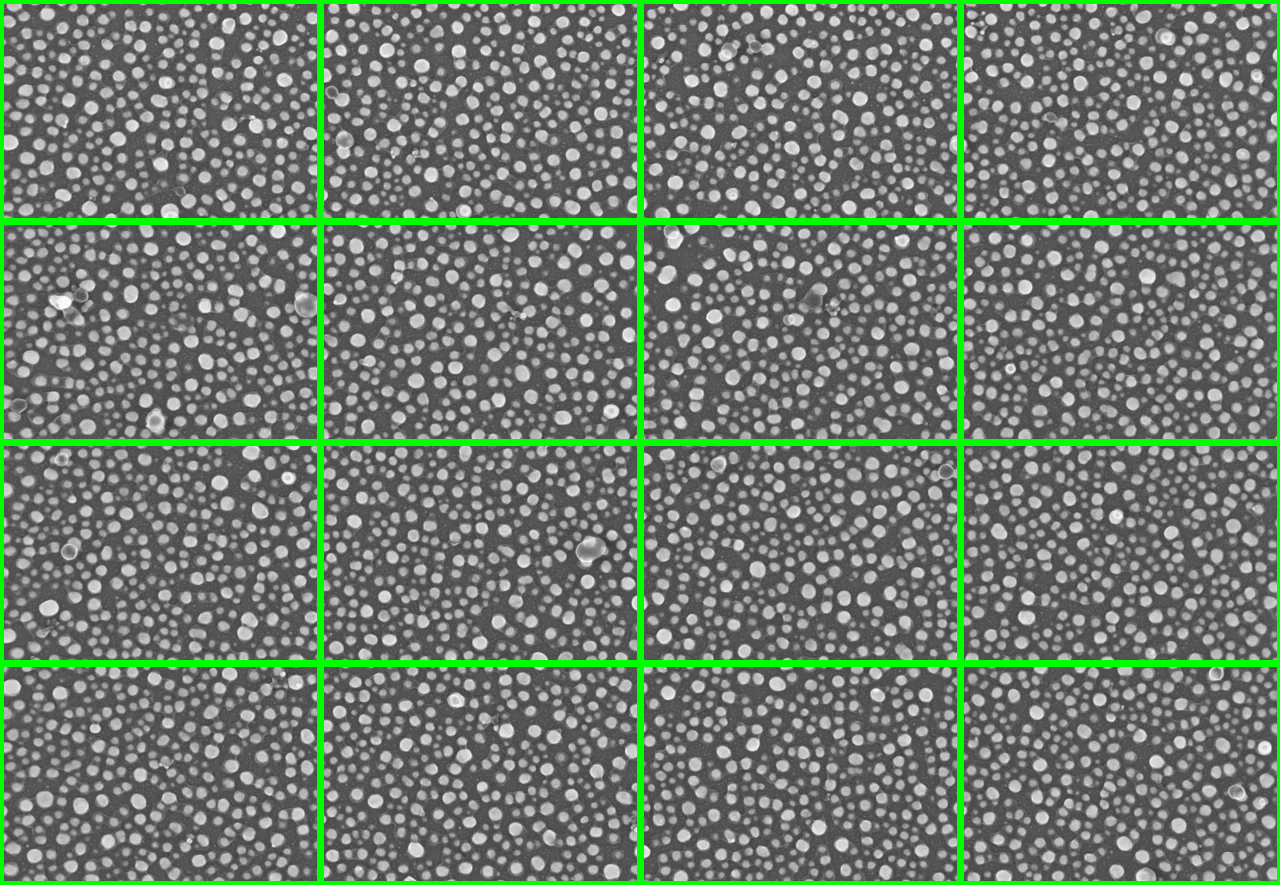

In [ ]:
# показать чанкинг
ch_full = chunks_show(img,img_size_nm)
cv2_imshow(ch_full)

(442, 640)


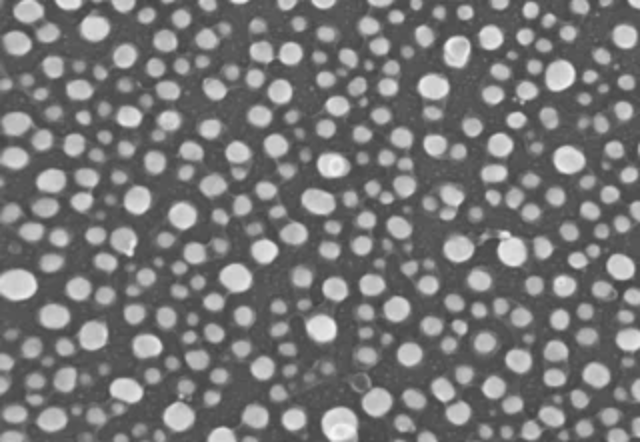

In [ ]:
# взять один из кусочков
roi_img = imgs_chunks[0]
# привести к размеру 640 по ширине
scale = 640//roi_img.shape[1]
roi_img = cv2.resize(roi_img, (int(roi_img.shape[1]*scale), int(roi_img.shape[0]*scale)))
print(roi_img.shape)
# roi_img = img.copy()
roi_img_rgb = make_rgb(roi_img)
cv2_imshow(roi_img_rgb)

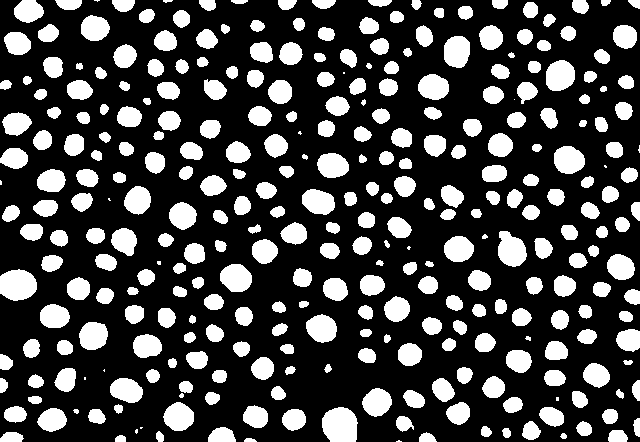

In [ ]:
# получить бинарное
blur = cv2.medianBlur(roi_img, 1)
binary_img = make_tresh(blur,150)
binary_img = make_rgb(binary_img)
cv2_imshow(binary_img)


0: 448x640 145 clstrs, 239.1ms
Speed: 4.3ms preprocess, 239.1ms inference, 855.2ms postprocess per image at shape (1, 3, 448, 640)


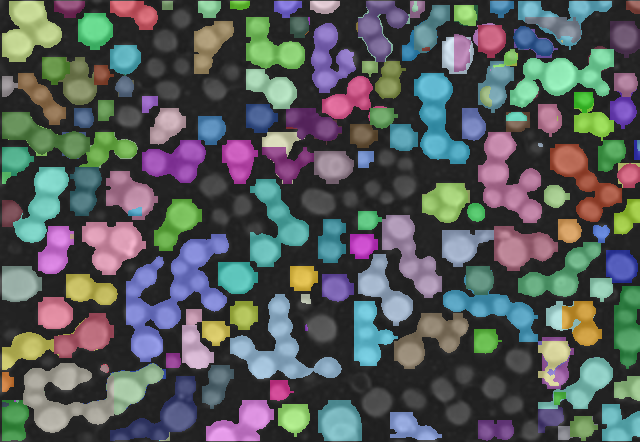

In [ ]:
# РЕЗУЛЬТАТ YOLO
H, W, _ = binary_img.shape

model = YOLO(model_path)
results = model(binary_img)

contours_img = create_blank_img(binary_img.shape)

for result in results:
    for j, mask in enumerate(result.masks.data):
        mask = (mask.cpu().numpy() * 255).astype(np.uint8)
        mask = cv2.resize(mask, (W, H))

        contours,hierarchy = cv2.findContours(mask,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
        for c in contours:
            color = list(np.random.random(size=3) * 256)
            cv2.fillPoly(contours_img, pts =[c], color=color)

alpha = 0.4
yolo_result = cv2.addWeighted(roi_img_rgb, alpha,contours_img , (1.0 - alpha), 0.0)
cv2_imshow(yolo_result)

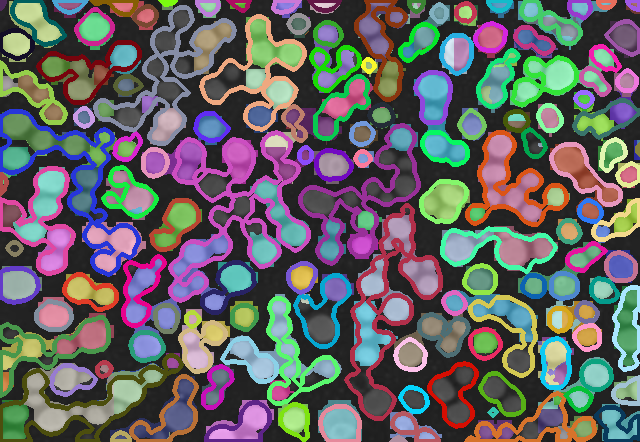

In [ ]:
# CV2 RESULT
filtered_img = get_filtered_tresh_100nm(roi_img)
contours, hierarchy = cv2.findContours(filtered_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

img_rgb = make_rgb(roi_img)
cv2_result =  create_blank_img(img_rgb.shape)
check_result = yolo_result.copy()
for c in contours:
    color = list(np.random.random(size=3) * 256)
    cv2.fillPoly(cv2_result, pts =[c], color=color)
    cv2.drawContours(check_result,[c], 0, color,3,)

alpha = 0.4
cv2_result = cv2.addWeighted(img_rgb, alpha, cv2_result, (1.0 - alpha), 0.0)
# cv2_imshow(cv2_result)
cv2_imshow(check_result)
# показывает наложение cv2 на результат YOLO


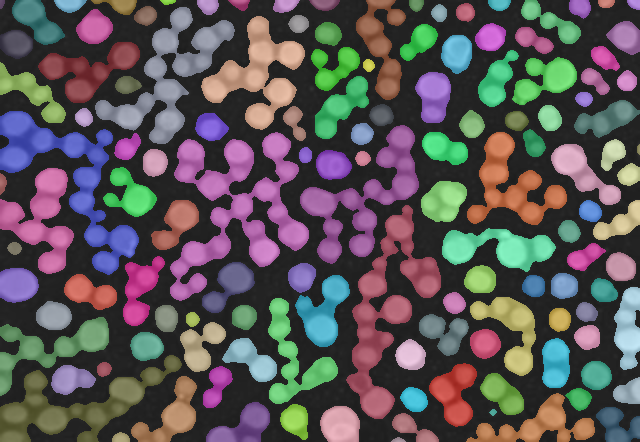

In [ ]:
cv2_imshow(cv2_result)
# результат cv2 в чистом виде

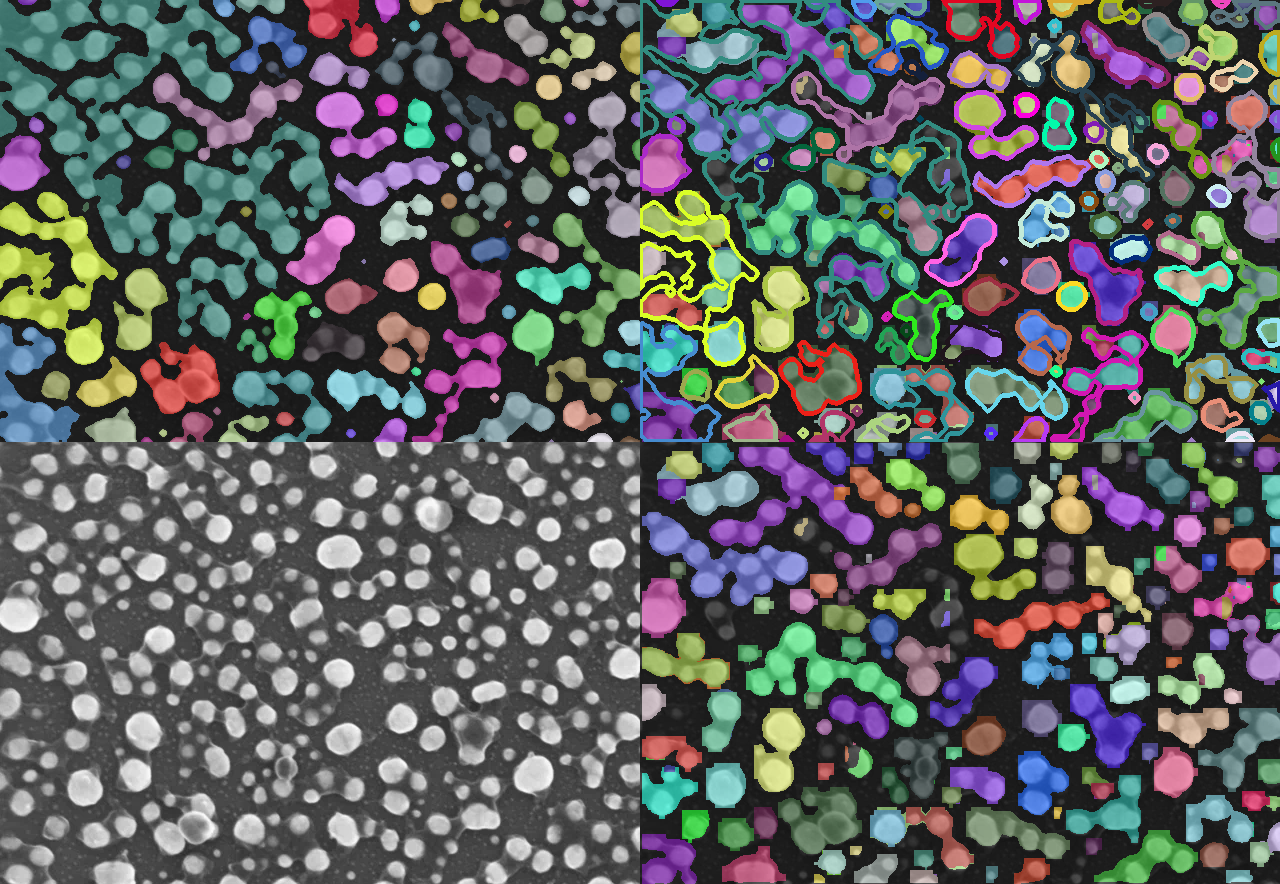

In [ ]:
# COMBO:
# concat_cv2_yolo = np.concatenate((yolo_result, check_result), axis=1)
# concat_roi_cv2 = np.concatenate((roi_img_rgb, cv2_result), axis=1)
# concat_full = np.concatenate((concat_roi_cv2, concat_cv2_yolo), axis=0)

# filtered_img_rgb = make_rgb(filtered_img)
concat_cv2_yolo = np.concatenate((cv2_result, check_result ), axis=1)
concat_roi_cv2 = np.concatenate((roi_img_rgb, yolo_result), axis=1)
concat_full = np.concatenate((concat_cv2_yolo, concat_roi_cv2 ), axis=0)

cv2_imshow(concat_full)
# показывает комбинированное изображение для сравнения